# Revisar el cuaderno auxiliar 
Pegar aquí la url del git hub

In [1]:
import os
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt

# ==========================
# 1) Cargar datos
# ==========================
data = pd.read_csv("train.csv")  # asegúrate que 'Survived' exista
data


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [2]:
# ==========================
# Definir variable target
# ==========================
target = "Survived"
assert target in data.columns, f"'{target}' no está en las columnas: {list(data.columns)[:10]}..."

# Eliminar filas con target nulo (por seguridad)
data = data.dropna(subset=[target])

In [3]:
# ==========================
# 2) Split
# ==========================
X = data.drop(columns=[target])   # todas las variables menos Survived
y = data[target]                  # la variable objetivo

# División estratificada para mantener proporciones de sobrevivientes
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

Matriz de Confusión (conteos)          Pred: 0  Pred: 1
Real: 0      100       10
Real: 1       25       44
              precision    recall  f1-score   support

           0     0.8000    0.9091    0.8511       110
           1     0.8148    0.6377    0.7154        69

    accuracy                         0.8045       179
   macro avg     0.8074    0.7734    0.7833       179
weighted avg     0.8057    0.8045    0.7988       179



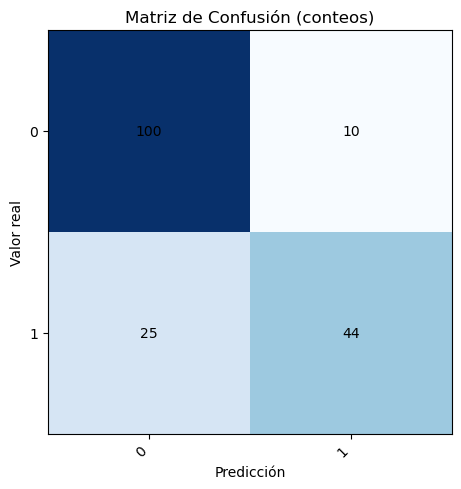

In [4]:
# ==========================
# 3) Preprocessing
# ==========================
cat_features = X_train.select_dtypes(include=["object", "category"]).columns.tolist()
num_features = X_train.select_dtypes(include=["number"]).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_features),
    ],
    remainder="drop",
)

# ==========================
# 4) Model (baseline: Random Forest)
# ==========================
model = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)

pipe = Pipeline(steps=[
    ("prep", preprocessor),
    ("model", model)
])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

# ==========================
# 5) Confusion Matrix
# ==========================
labels = sorted(pd.unique(y_test))
cm = confusion_matrix(y_test, y_pred, labels=labels)
cm_df = pd.DataFrame(
    cm,
    index=[f"Real: {lbl}" for lbl in labels],
    columns=[f"Pred: {lbl}" for lbl in labels]
)

# Normalizada (por filas)
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
cm_norm = np.nan_to_num(cm_norm)

print("Matriz de Confusión (conteos)", cm_df)

# ==========================
# 6) Plot confusion matrix
# ==========================
fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(cm, cmap="Blues")

# Ticks y labels
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=45, ha="right")
ax.set_yticklabels(labels)
ax.set_xlabel("Predicción")
ax.set_ylabel("Valor real")
ax.set_title("Matriz de Confusión (conteos)")

# Conteos en cada celda
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, str(cm[i, j]), ha="center", va="center")

plt.tight_layout()

# Guardar resultados
fig_path = "confusion_matrix.png"
csv_counts_path = "confusion_matrix_counts.csv"

plt.savefig(fig_path, dpi=150, bbox_inches="tight")
cm_df.to_csv(csv_counts_path, index=True)

# ==========================
# 7) Classification report
# ==========================
report = classification_report(y_test, y_pred, digits=4, output_dict=False)
print(report)

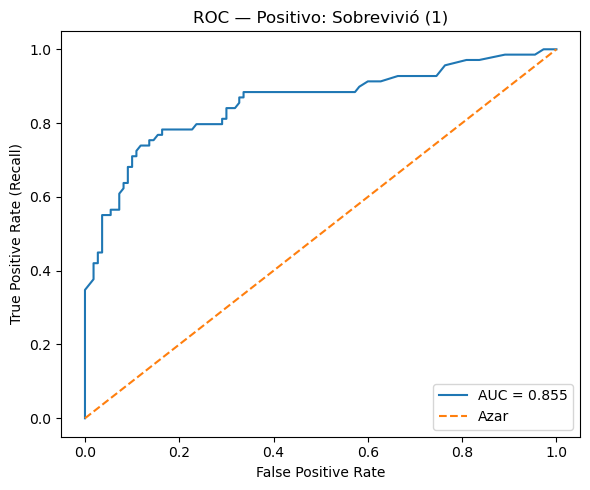

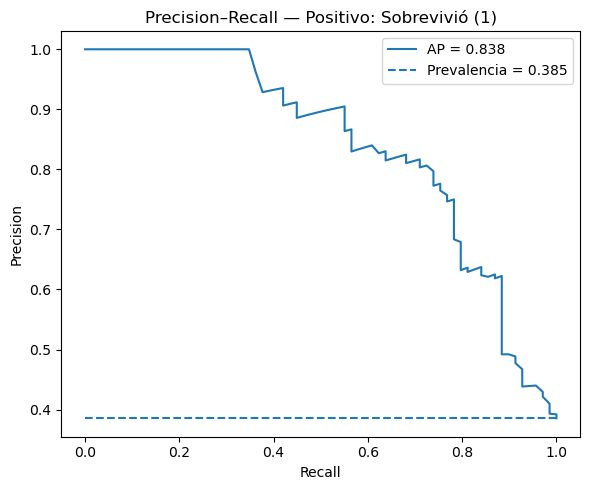

[BINARIO] AUC-ROC: 0.855 | AP (área PR): 0.838 | Prevalencia: 0.385


In [5]:
# ==========================
# ROC y PR para Titanic (binario: Survived)
# ==========================
import numpy as np
from sklearn.metrics import (
    roc_curve, auc, roc_auc_score,
    precision_recall_curve, average_precision_score
)
import matplotlib.pyplot as plt

# 1) Obtener puntajes del pipeline ya entrenado
model = pipe.named_steps["model"]
if hasattr(model, "predict_proba"):
    y_score = pipe.predict_proba(X_test)  # (n_samples, n_classes)
elif hasattr(model, "decision_function"):
    scores = pipe.decision_function(X_test)
    y_score = scores if scores.ndim > 1 else np.c_[1 - scores, scores]
else:
    raise ValueError("El modelo no tiene predict_proba ni decision_function.")

classes = getattr(model, "classes_", np.unique(y_test))
classes = np.array(classes)
n_classes = len(classes)

# ==========================
# Caso BINARIO (Survived = 0/1)
# ==========================
if n_classes == 2:
    pos_label = 1  # en Titanic, 1 = sobrevivió
    pos_idx = int(np.where(classes == pos_label)[0][0])
    y_scores_pos = y_score[:, pos_idx]

    # ROC
    fpr, tpr, _ = roc_curve(y_test, y_scores_pos, pos_label=pos_label)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0,1],[0,1],"--", label="Azar")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.title("ROC — Positivo: Sobrevivió (1)")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

    # Precision–Recall
    precision, recall, _ = precision_recall_curve(y_test, y_scores_pos, pos_label=pos_label)
    ap = average_precision_score(y_test, y_scores_pos, pos_label=pos_label)
    prevalence = float((y_test == pos_label).mean())

    plt.figure(figsize=(6,5))
    plt.plot(recall, precision, label=f"AP = {ap:.3f}")
    plt.hlines(prevalence, 0, 1, linestyles="--", label=f"Prevalencia = {prevalence:.3f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision–Recall — Positivo: Sobrevivió (1)")
    plt.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

    print(f"[BINARIO] AUC-ROC: {roc_auc:.3f} | AP (área PR): {ap:.3f} | Prevalencia: {prevalence:.3f}")


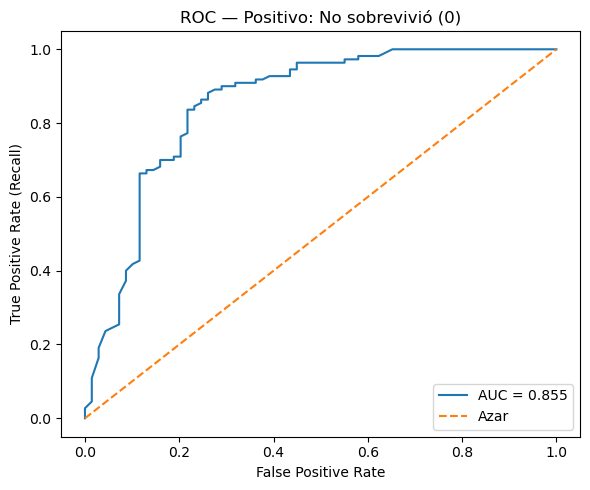

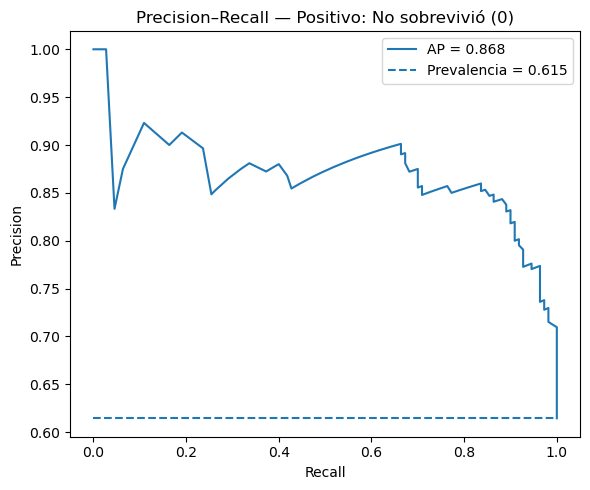

[Clase 0] AUC-ROC: 0.855 | AP: 0.868 | Prevalencia: 0.615


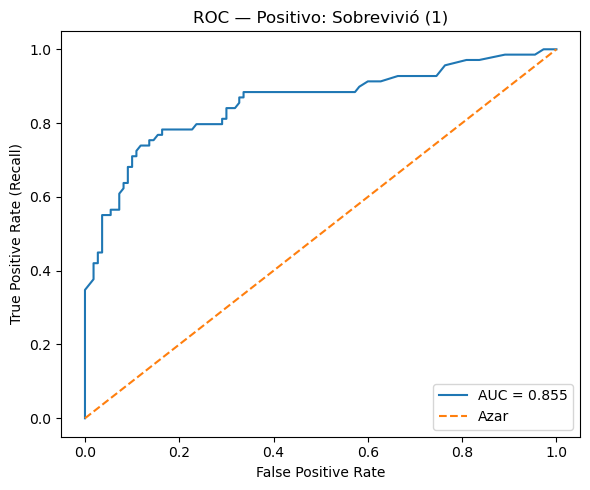

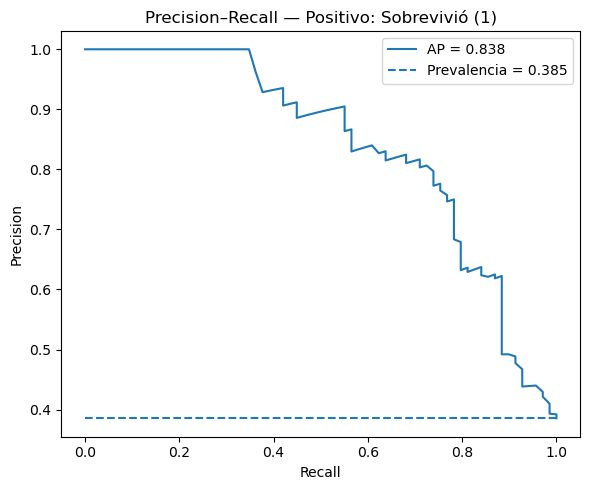

[Clase 1] AUC-ROC: 0.855 | AP: 0.838 | Prevalencia: 0.385


In [6]:
# ==========================
# ROC y PR para ambas clases — Titanic
# ==========================
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

def roc_pr_for_class(pipe, X_test, y_test, pos_label):
    model = pipe.named_steps["model"]
    classes = model.classes_
    assert pos_label in classes, f"{pos_label} no está en {classes}"
    pos_idx = int(np.where(classes == pos_label)[0][0])
    y_score = pipe.predict_proba(X_test)[:, pos_idx]
    prevalence = float((y_test == pos_label).mean())

    # ROC
    fpr, tpr, _ = roc_curve(y_test, y_score, pos_label=pos_label)
    auc_roc = auc(fpr, tpr)

    # PR
    prec, rec, _ = precision_recall_curve(y_test, y_score, pos_label=pos_label)
    ap = average_precision_score(y_test, y_score, pos_label=pos_label)

    # Graficar ROC
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"AUC = {auc_roc:.3f}")
    plt.plot([0,1],[0,1],"--", label="Azar")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    if pos_label == 1:
        plt.title("ROC — Positivo: Sobrevivió (1)")
    else:
        plt.title("ROC — Positivo: No sobrevivió (0)")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

    # Graficar PR
    plt.figure(figsize=(6,5))
    plt.plot(rec, prec, label=f"AP = {ap:.3f}")
    plt.hlines(prevalence, 0, 1, linestyles="--", label=f"Prevalencia = {prevalence:.3f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    if pos_label == 1:
        plt.title("Precision–Recall — Positivo: Sobrevivió (1)")
    else:
        plt.title("Precision–Recall — Positivo: No sobrevivió (0)")
    plt.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

    print(f"[Clase {pos_label}] AUC-ROC: {auc_roc:.3f} | AP: {ap:.3f} | Prevalencia: {prevalence:.3f}")

# ==========================
# Ejecutar para ambas clases (0 = no sobrevivió, 1 = sobrevivió)
# ==========================
for lbl in pipe.named_steps["model"].classes_:
    roc_pr_for_class(pipe, X_test, y_test, pos_label=lbl)


Interpretación de métricas con `respiralimpio_data_clean.csv` (target = `State`)

> Configuración: modelo **RandomForest** con preprocesamiento (OneHotEncoder + StandardScaler). Positivo para las curvas: **`1 = SOBREVIVIÓ`**.  
> Conjunto de prueba ≈ 20% del dataset.

---

## 1) Matriz de Confusión (binario)

| Real \ Predicho | **SOBREVIVIÓ** | **NO SOBREVIVIÓ** |
|---|---:|---:|
| **SOBREVIVIÓ**      | **TP = 44** | **FN = 25**  |
| **NO SOBREVIVIÓ**   | **FP = 10**  | **TN = 100** |

- **Precision(SOBREVIVIÓ)** = `TP / (TP + FP)` = 44 / (44 + 10) ≈ **0.815**  
- **Recall(SOBREVIVIÓ)**    = `TP / (TP + FN)` = 44 / (44 + 25) ≈ **0.638**  
- **FPR**                   = `FP / (FP + TN)` = 10 / (10 + 100) ≈ **0.091**  
- **Accuracy global** ≈ **0.805**

> Lectura: a umbral ~0.5, el modelo Detecta bien a los que no sobrevivieron (recall = 91% para clase 0), detecta peor a los sobrevivientes (recall ≈ 64%), de los predichos como sobrevivientes, ~81.5% realmente sobrevivieron (precisión aceptable) y globalmente, el modelo clasifica bien 8 de cada 10 pasajeros.

---

## 2) Curva ROC (Receiver Operating Characteristic)

- **AUC-ROC ≈ 0.80** → **discriminación buena** (0.5 = azar, 1.0 = perfecto).  
- Probabilística: hay ~**80%** de probabilidad de asignar un score mayor a un pasajero que **SOBREVIVIÓ (1)** que a uno que **NO SOBREVIVIÓ (0)** tomado al azar.  
- Intercambio (trade-off): Si subes el umbral → ↓FPR (menos falsos positivos), pero también ↓Recall (se te escapan sobrevivientes reales) y si bajas el umbral → ↑Recall (detectas más sobrevivientes), pero ↑FPR (clasificas erróneamente más no sobrevivientes como sobrevivientes).

> Nota: en binario, si cambias la clase positiva a `NO SOBREVIVIÓ (0)`, el **AUC-ROC numéricamente no cambia**.

---

## 3) Curvas Precision–Recall (PR)

**Por clase (One-vs-Rest):**

| Clase                | AP (área PR) | Prevalencia |
|----------------------|:------------:|:-----------:|
| `SOBREVIVIÓ (1)`     | **0.720**    | **0.385**   |
| `NO SOBREVIVIÓ (0)`  | **0.840**    | **0.615**   |

- Estar **por encima** de la línea de **prevalencia** indica valor sobre el azar dado el desbalance.  
- La clase **`NO SOBREVIVIÓ (0)`** muestra **mejor separación** (AP=0.840) que la clase `SOBREVIVIÓ` (AP=0.720).

**Métricas por clase (umbral ~0.5):**

| Clase                  | Precision  | Recall  | F1    | Soporte |
|------------------------|:----------:|:-------:|:-----:|:-------:|
| `NO SOBREVIVIÓ (0)`    | **0.8000** | 0.9091  | 0.8511|   110   |
| `SOBREVIVIÓ (1)`       | **0.8148** | 0.6377  | 0.7154|   69    |

> Conclusión PR: **el modelo rinde mejor para `NO SOBREVIVIÓ (0)`** (AP y F1 mayores; precision mayor (≈91%))
> Para **SOBREVIVIÓ (1)** → precision aceptable (≈81%), pero su recall es bajo (≈64%), lo que significa que el modelo deja escapar a varios sobrevivientes reales.
---

## 4) Trade-off del umbral (threshold)

- **Subir** umbral ⇒ **↑ Precision**, **↓ Recall**, **↓ FPR** (predecimos sobrevivir solo con scores altos → cometes menos falsos “sobrevivió”, pero dejas escapar más sobrevivientes reales).  
- **Bajar** umbral ⇒ **↓ Precision**, **↑ Recall**, **↑ FPR** (detectas más sobrevivientes reales, pero también clasificas erróneamente como sobrevivientes a más que en realidad no lo hicieron).  

**Criterios para elegir umbral:**
1. **Máximo F1** → equilibrio general entre Precision y Recall.  
2. **Precision mínima** (p.ej., ≥ 0.75) → prioriza **reducir FP** (menos falsos sobrevivientes).  
3. **Recall mínimo** (p.ej., ≥ 0.85) → prioriza **no perder sobrevivientes** (menos falsos rechazados).  
4. **Umbral por costos**  
   \[
   t^\*=\frac{C_{FP}}{C_{FP}+C_{FN}}
   \]
   con \(C_{FP}\)= costo de un falso **sobrevivió** y \(C_{FN}\)= costo de un falso **no sobrevivió**.

> Conclusión: En Titanic, si nuestro objetivo es rescatar la mayor cantidad posible de sobrevivientes (clase 1), deberíamos elegir un umbral más bajo (favorecer recall).
Si, en cambio, quisiéramos ser más estricto y evitar falsos sobrevivientes, elegiríamos un umbral más alto (favorecer precision).
---

## 5) Recomendaciones didácticas

- Mostrar **cómo cambia la matriz de confusión** cuando se mueve el umbral (p.ej., máximo F1 vs. precision objetivo).
    - Ejemplo: comparar la matriz con el umbral por defecto (0.5) vs. el umbral que maximiza F1, o el que asegura Precision ≥ 0.75.
    - Esto permite visualizar el trade-off entre atrapar más sobrevivientes (recall) y equivocarse menos (precision).
- Comparar **ROC vs. PR**: en desbalance, **PR** suele ser más informativa.
    - Titanic tiene cierto desbalance (más pasajeros que no sobrevivieron que los que sí).
    - En estos casos, la curva PR (Precision–Recall) suele dar una visión más clara que ROC sobre cómo el modelo maneja a los sobrevivientes (clase minoritaria).
- Incluir **calibración de probabilidades** (Platt/Isotónica) antes de fijar umbrales por costo.
    - Los modelos como RandomForest a veces producen probabilidades mal calibradas (scores que no reflejan probabilidades reales).
    - Técnicas como Platt Scaling o Regresión Isotónica pueden mejorar esa calibración, y con ello, la elección de umbrales basados en probabilidades.
- Probar **modelos de boosting** (XGBoost/LightGBM) y **nuevas variables** para mejorar AUC y AP.
    - Usar XGBoost, LightGBM o CatBoost con buen ajuste de hiperparámetros.
    - Estos modelos suelen mejorar la discriminación, logrando mayor AUC y AP, sobre todo en datasets como Titanic con mezcla de variables numéricas y categóricas.

- Ingeniería de nuevas variables
    - Crear variables derivadas:
        - FamilySize = SibSp + Parch + 1
        - IsAlone = indicador de pasajeros sin familiares
        - Title extraído de la columna Name (Mr, Miss, etc.)
    - Estas variables suelen mejorar bastante el rendimiento del modelo en Titanic.
---

In [7]:
# ==========================
# Recomendación 1
# ==========================

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    precision_recall_curve, roc_curve, auc,
    confusion_matrix, f1_score
)

# ==========================
# 1) Umbrales y matrices de confusión
# ==========================

# Probabilidades predichas para la clase positiva (1 = sobrevivió)
y_proba = pipe.predict_proba(X_test)[:, 1]

# Umbral por defecto (0.5)
y_pred_05 = (y_proba >= 0.5).astype(int)

# Umbral óptimo por F1
prec, rec, thr = precision_recall_curve(y_test, y_proba, pos_label=1)
f1_scores = 2 * (prec * rec) / (prec + rec + 1e-8)
best_idx = np.argmax(f1_scores)
best_thr = thr[best_idx]
y_pred_f1 = (y_proba >= best_thr).astype(int)

print(f"Umbral por defecto = 0.5 | Umbral óptimo F1 = {best_thr:.3f}")

# Matriz de confusión en ambos casos
cm_05 = confusion_matrix(y_test, y_pred_05)
cm_f1 = confusion_matrix(y_test, y_pred_f1)

print("\nMatriz de Confusión (umbral=0.5):\n", cm_05)
print("\nMatriz de Confusión (umbral=F1 óptimo):\n", cm_f1)

Umbral por defecto = 0.5 | Umbral óptimo F1 = 0.443

Matriz de Confusión (umbral=0.5):
 [[100  10]
 [ 24  45]]

Matriz de Confusión (umbral=F1 óptimo):
 [[97 13]
 [18 51]]


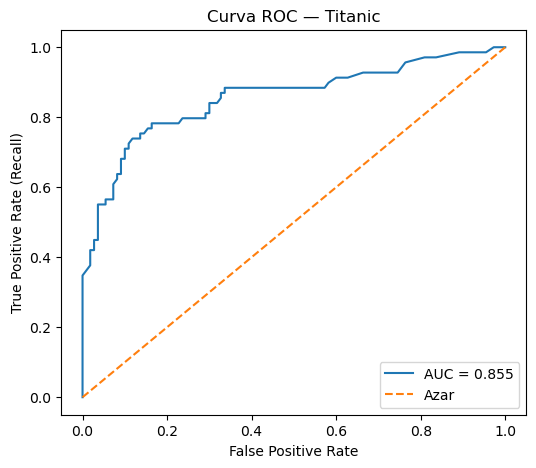

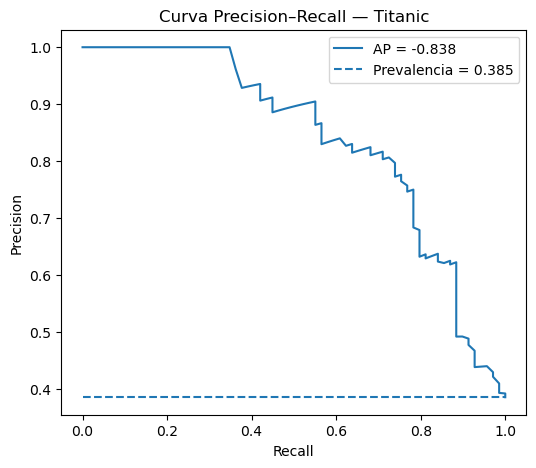

In [8]:
# ==========================
# Recomendación 2
# ==========================

# ==========================
# 2) Comparación ROC vs PR
# ==========================

# ROC
fpr, tpr, _ = roc_curve(y_test, y_proba, pos_label=1)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1],'--', label="Azar")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("Curva ROC — Titanic")
plt.legend(loc="lower right")
plt.show()

# Precision–Recall
precision, recall, _ = precision_recall_curve(y_test, y_proba, pos_label=1)
ap = np.trapz(precision, recall)  # área aproximada bajo curva PR

plt.figure(figsize=(6,5))
plt.plot(recall, precision, label=f"AP = {ap:.3f}")
prevalence = (y_test == 1).mean()
plt.hlines(prevalence, 0, 1, linestyles="--", label=f"Prevalencia = {prevalence:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva Precision–Recall — Titanic")
plt.legend(loc="upper right")
plt.show()

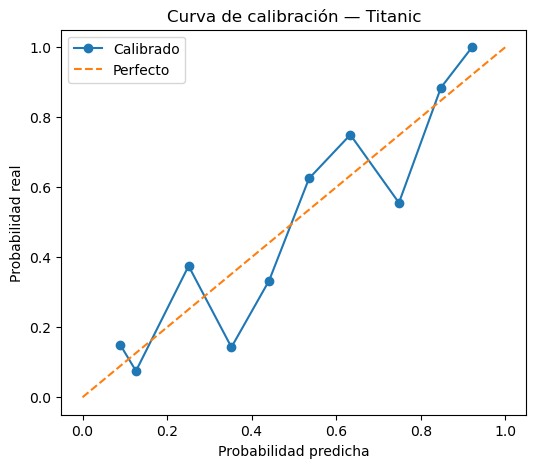

In [9]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

# ==========================
# Recomendación 3
# ==========================

# Reentrenar modelo con calibración (sigmoid o isotonic)
calibrated_pipe = CalibratedClassifierCV(pipe.named_steps["model"], cv=5, method="sigmoid")

# Entrenar sobre features ya transformadas (evitamos recalibrar el preprocesador)
X_train_prep = pipe.named_steps["prep"].fit_transform(X_train)
X_test_prep = pipe.named_steps["prep"].transform(X_test)

calibrated_pipe.fit(X_train_prep, y_train)

# Probabilidades calibradas
y_proba_cal = calibrated_pipe.predict_proba(X_test_prep)[:, 1]

# Comparar curva de calibración
prob_true, prob_pred = calibration_curve(y_test, y_proba_cal, n_bins=10)

plt.figure(figsize=(6,5))
plt.plot(prob_pred, prob_true, marker="o", label="Calibrado")
plt.plot([0,1],[0,1],"--", label="Perfecto")
plt.xlabel("Probabilidad predicha")
plt.ylabel("Probabilidad real")
plt.title("Curva de calibración — Titanic")
plt.legend()
plt.show()


In [10]:
#Este modelo nos menciona si sobreestima o subestima las probabilidades

In [13]:
# - Recomendación 4 (Umbral por costos): ajusta el umbral de decisión según qué error quieras evitar más:

#   - Si perder un sobreviviente (FN) es más grave → bajas el umbral.

#   - Si clasificar erróneamente como sobreviviente a alguien que no lo hizo (FP) es más grave → subes el umbral.

Umbral por defecto = 0.5 | Umbral óptimo F1 = 0.443 | Umbral por costos = 0.167


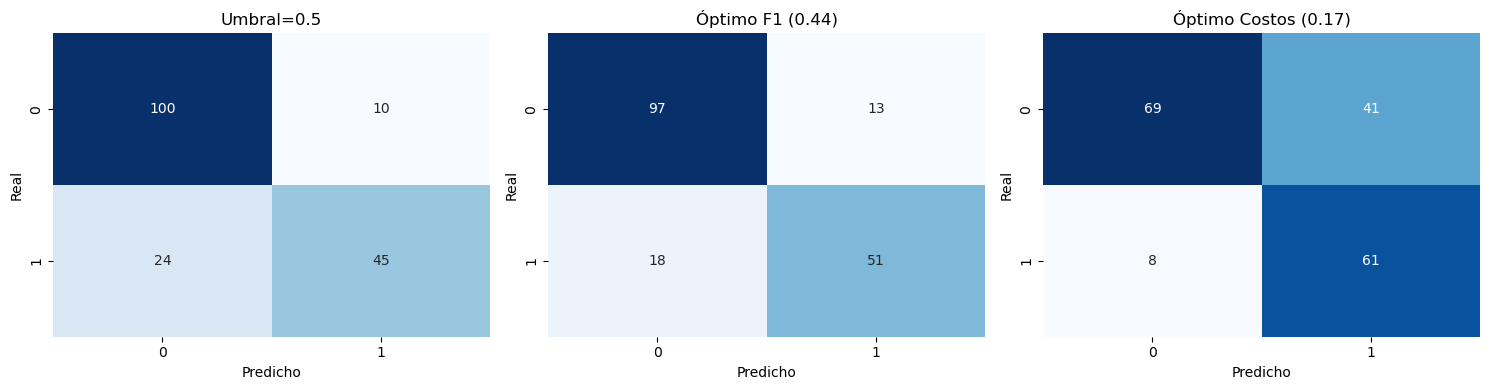

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_curve, f1_score

# ==========================
# 1) Probabilidades del modelo
# ==========================
y_proba = pipe.predict_proba(X_test)[:, 1]

# ==========================
# 2) Umbral por defecto (0.5)
# ==========================
y_pred_05 = (y_proba >= 0.5).astype(int)
cm_05 = confusion_matrix(y_test, y_pred_05)

# ==========================
# 3) Umbral óptimo por F1
# ==========================
prec, rec, thr = precision_recall_curve(y_test, y_proba, pos_label=1)
f1_scores = 2 * (prec * rec) / (prec + rec + 1e-8)
best_idx = np.argmax(f1_scores)
best_thr = thr[best_idx]

y_pred_f1 = (y_proba >= best_thr).astype(int)
cm_f1 = confusion_matrix(y_test, y_pred_f1)

# ==========================
# 4) Umbral óptimo por costos
# ==========================
C_FP, C_FN = 1, 5
t_cost = C_FP / (C_FP + C_FN)

y_pred_cost = (y_proba >= t_cost).astype(int)
cm_cost = confusion_matrix(y_test, y_pred_cost)

print(f"Umbral por defecto = 0.5 | Umbral óptimo F1 = {best_thr:.3f} | Umbral por costos = {t_cost:.3f}")

# ==========================
# 5) Visualización comparativa
# ==========================
cms = [cm_05, cm_f1, cm_cost]
titles = [f"Umbral=0.5", f"Óptimo F1 ({best_thr:.2f})", f"Óptimo Costos ({t_cost:.2f})"]

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for ax, cm, title in zip(axes, cms, titles):
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
    ax.set_xlabel("Predicho")
    ax.set_ylabel("Real")
    ax.set_title(title)

plt.tight_layout()
plt.show()


In [15]:
# - Tres matrices de confusión lado a lado, comparando:

#   - Umbral fijo (0.5).

#   - Óptimo F1 (equilibrio entre precision y recall).

#   - Óptimo por costos (según la importancia que des a FP y FN).

# - Así podemos ver cómo se mueve el balance de aciertos y errores al cambiar el umbral.